# Глубинное обучение, ИИ ВШЭ

## Домашнее задание 2. Классификация при помощи CNN. 

### Общая информация

### Оценивание и штрафы

Максимально допустимая оценка за работу без бонусов — 10 баллов. Сдавать задание после указанного срока жесткого дедлайна нельзя.

Сдача работы после мягкого дедлайна штрафуется ступенчато, -1 балл в сутки. Один раз за модуль студентам предоставляется возможность использовать отсрочку и сдать в жесткий дедлайн без штрафа.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

Использование генеративных моделей допустимо на следующих условиях:
- Количество кода, написанное генеративными моделями, не превышает 30%
- Указана модель, использованная для генерации, а также промпт
- В конце работы необходимо описать свой опыт использования генеративного ИИ для решения данного домашнего задания. Укажите как часто Вам приходилось исправлять код своими руками или просить модель что-то исправить. Было ли это быстрее, чем написать код самим? 

В случае невыполнения этих требований работа не оценивается и оценка за неё не превышает 0 баллов.

### О задании

В этом задании вам предстоит познакомиться со сверточными сетями и их обучением для классификации изображений с использованием библиотеки PyTorch.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

# В доке советуют использовать v2
# import torchvision.transforms as transforms
from torchvision.transforms import v2 as transforms

from sklearn.model_selection import train_test_split

## 0. Загрузка данных

Работать мы будем с набором данных [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). CIFAR10 представляет собой набор изображений 32х32 пикселя, разделенных на 10 классов.

![title](https://pytorch.org/tutorials/_images/cifar10.png)




Набор данных уже определен в <code>torchvision.datasets</code>, так что возьмем его оттуда. 



In [2]:
# Для тру нормализации
mean = (0.4914, 0.4822, 0.4465)
std = (0.2470, 0.2435, 0.2616)
# Тут взяты значения как в одном из туториалов пайторча :)


def get_cifar10_data(batch_size, transform_train):
    torch.manual_seed(0)
    np.random.seed(0)

    transform_test = transforms.Compose(
        [
            # Переделаем под v2
            # transforms.ToTensor(),
            transforms.ToImage(),
            transforms.ToDtype(torch.float32, scale=True),
            # Переводим цвета пикселей в отрезок [-1, 1]
            transforms.Normalize(mean, std),
        ]
    )

    # Загружаем данные
    trainvalset = torchvision.datasets.CIFAR10(
        root="./data", train=True, download=True, transform=transform_train
    )
    testset = torchvision.datasets.CIFAR10(
        root="./data", train=False, download=True, transform=transform_test
    )

    # В датасете определено разбиение только на train и test,
    # так что валидацию дополнительно выделяем из обучающей выборки
    train_idx, valid_idx = train_test_split(
        np.arange(len(trainvalset)), test_size=0.3, shuffle=True, random_state=0
    )
    trainset = torch.utils.data.Subset(trainvalset, train_idx)
    valset = torch.utils.data.Subset(trainvalset, valid_idx)

    train_loader = torch.utils.data.DataLoader(
        trainset, batch_size=batch_size, shuffle=True, num_workers=2
    )
    val_loader = torch.utils.data.DataLoader(
        valset, batch_size=batch_size, shuffle=False, num_workers=2
    )
    test_loader = torch.utils.data.DataLoader(
        testset, batch_size=batch_size, shuffle=False, num_workers=2
    )

    return train_loader, val_loader, test_loader

In [3]:
transform = transforms.Compose(
    # Переделаем под v2
    # [transforms.ToTensor(), transforms.Normalize(mean, std)]
    [
        transforms.ToImage(),
        transforms.ToDtype(torch.float32, scale=True),
        transforms.Normalize(mean, std)
    ]
)

train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=64, transform_train=transform
)

Посмотрим на изображения:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.49473685..1.5632443].


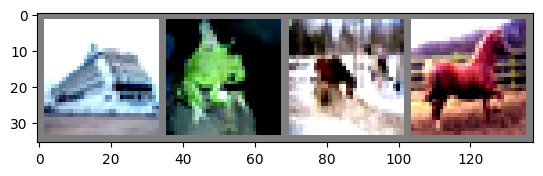

ship frog horse horse


In [4]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)
print(*[classes[labels[i]] for i in range(4)])

## 1. Задание сверточной сети (3 балла)

Теперь нам нужно задать сверточную нейронную сеть, которую мы будем обучать классифицировать изображения.

Используем сеть, основанную на одном блоке архитектуры, похожей на ResNet. Обратите внимание, это не ResNet 1 в 1.

<img src="https://i.ibb.co/2hg962h/basic-block.png" width="500"/>

__Указания:__

- Все сверточные слои должны иметь 32 выходных канала, а также не должны изменять ширину и высоту изображения.
- Выход блока сократите до размерности 32х4х4, применив average pooling.
- Для получения итоговых логитов, распрямите выход пулинга в вектор из 512 элементов, а затем пропустите его через линейный слой.

**Задание 1.1 (3 балла).**

Определите архитектуру сети соответственно схеме и указаниям выше.

Ключевые слова: <code>Conv2d</code>, <code>BatchNorm2d</code>, <code>AvgPool2d</code>.

In [5]:
n_classes = 10

class BasicBlockNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.seq = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=32),
        )
        self.conv = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=1)
        self.out = nn.Sequential(
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=8),
            nn.Flatten(),
            nn.Linear(in_features=512, out_features=10)
        )

    def forward(self, x):
        out_seq = self.seq(x)
        out_conv = self.conv(x)
        out = self.out(out_seq + out_conv)
        return out

In [6]:
net = BasicBlockNet()
net

BasicBlockNet(
  (seq): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
  (out): Sequential(
    (0): ReLU()
    (1): AvgPool2d(kernel_size=8, stride=8, padding=0)
    (2): Flatten(start_dim=1, end_dim=-1)
    (3): Linear(in_features=512, out_features=10, bias=True)
  )
)

Проверим, что выход сети имеет корректную размерность:

In [7]:
assert net(torch.zeros((10, 3, 32, 32))).shape == (10, 10)

Чтобы проводить вычисления на GPU, в PyTorch необходимо руками перекладывать объекты, с которыми вы хотите проводить вычисления, на графический ускоритель. Это делается следующим образрм:

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [9]:
net = net.to(device)

Подключение GPU в google.colab:

**Среда выполнения** -> **Сменить среду выполнения** -> **Аппаратный ускоритель** -> **GPU**

## 2. Обучение и тестирование модели (3 балла)

**Задание 2.1 (2 балла).** Переходим к обучению модели. Заполните пропуски в функциях <code>test</code> и <code>train_epoch</code>. В качестве функции потерь будем использовать [кросс-энтропию](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html), а в качестве метрики качества accuracy.

In [10]:
@torch.no_grad()
def test(model, loader):
    loss_log = []
    acc_log = []
    criterion = nn.CrossEntropyLoss()

    model.eval()

    for data, target in loader:
        data, target = data.to(device), target.to(device)

        pred = model(data)

        loss = criterion(pred, target)
        loss_log.append(loss.item())

        acc = torch.mean((torch.argmax(pred, axis=1) == target).float())
        acc_log.append(acc.item())

    return np.mean(loss_log), np.mean(acc_log)


def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    criterion = nn.CrossEntropyLoss()

    model.train()

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()

        pred = model(data)
        loss = criterion(pred, target)

        loss.backward()
        optimizer.step()

        acc = torch.mean((torch.argmax(pred, axis=1) == target).float())
        loss_log.append(loss.item())
        acc_log.append(acc.item())

    return loss_log, acc_log


def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)

        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss):.3f}, train acc: {np.mean(train_acc):.3f}")
        print(f" val loss: {val_loss:.3f}, val acc: {val_acc:.3f}\n")

        if scheduler is not None:
            # пригодится в части с перебором планировщиков
            if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_loss)
            else:
                scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

Запустим обучение модели. В качестве оптимизатора будем использовать стохастический градиентный спуск, который является де-факто стандартом в задачах компьютерного зрения (наравне с <code>Adam</code>).

__Замечание:__ Для достижения наилучшего качества в нашем случае потребуется обучать модель несколько сотен эпох. Однако в целях экономии вашего времени и сил, во всех экспериментах мы ограничимся 20 эпохами.

In [11]:
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, fused=True)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader
)

Epoch 0
 train loss: 1.498, train acc: 0.467
 val loss: 1.268, val acc: 0.554

Epoch 1
 train loss: 1.193, train acc: 0.579
 val loss: 1.162, val acc: 0.598

Epoch 2
 train loss: 1.059, train acc: 0.635
 val loss: 1.082, val acc: 0.625

Epoch 3
 train loss: 0.990, train acc: 0.654
 val loss: 1.051, val acc: 0.637

Epoch 4
 train loss: 0.953, train acc: 0.669
 val loss: 1.004, val acc: 0.652

Epoch 5
 train loss: 0.928, train acc: 0.677
 val loss: 0.944, val acc: 0.678

Epoch 6
 train loss: 0.897, train acc: 0.688
 val loss: 1.040, val acc: 0.648

Epoch 7
 train loss: 0.879, train acc: 0.695
 val loss: 0.929, val acc: 0.682

Epoch 8
 train loss: 0.862, train acc: 0.702
 val loss: 0.979, val acc: 0.664

Epoch 9
 train loss: 0.846, train acc: 0.708
 val loss: 0.962, val acc: 0.667

Epoch 10
 train loss: 0.831, train acc: 0.713
 val loss: 0.911, val acc: 0.693

Epoch 11
 train loss: 0.820, train acc: 0.717
 val loss: 0.877, val acc: 0.697

Epoch 12
 train loss: 0.805, train acc: 0.721
 val

Посчитайте точность на тестовой выборке:

In [12]:
test_loss, test_acc = test(net, test_loader)
print(f"Test loss: {test_loss:.3f}, accuracy: {test_acc:.3f}")

Test loss: 0.923, accuracy: 0.685


Если вы все сделали правильно, у вас должна была получиться точность $\ge 67\%$.

**Задание 2.2 (1 балл).** Постройте графики зависимости функции потерь и точности классификации от номера шага оптимизатора. На каждом графике расположите данные и для обучающей и для валидационной выборки, итого у вас должно получиться два графика. Обратите внимание, что на обучающей выборке эти данные считаются по каждому батчу, на валидационной же они считаются по всей выборке раз в эпоху.

In [13]:
batch_size = 64
n_epochs = len(val_loss_log)
n_batches = len(train_loader)

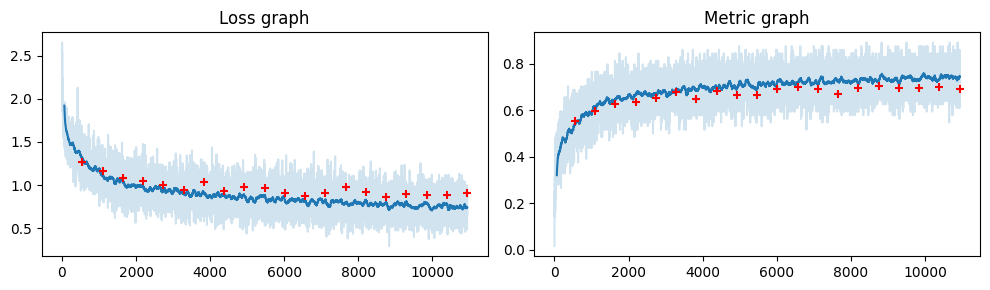

In [14]:
import pandas as pd


def plot_loss_metrics(train_loss, val_loss, train_metric, val_metric, batch_size=64):
    n_epochs = len(val_loss)
    n_batches = len(train_loss) // n_epochs

    plt.figure(figsize=(10, 3))

    plt.subplot(121)
    plt.plot(train_loss, alpha=0.2, color="C0", zorder=2)
    plt.plot(pd.Series(train_loss).rolling(batch_size).mean(), color="C0", zorder=1)
    plt.scatter(np.arange(1, n_epochs+1) * n_batches, val_loss, color="red", marker="+", zorder=3)
    plt.title("Loss graph")

    plt.subplot(122)
    plt.plot(train_metric, alpha=0.2, color="C0", zorder=2)
    plt.plot(pd.Series(train_metric).rolling(batch_size).mean(), color="C0", zorder=1)
    plt.scatter(np.arange(1, n_epochs+1) * n_batches, val_metric, color="red", marker="+", zorder=3)
    plt.title("Metric graph")

    plt.tight_layout()
    plt.show()

plot_loss_metrics(train_loss_log, val_loss_log, train_acc_log, val_acc_log)

## 3. Расписание длины шага (2 балла)

С курса "Машинное обучение 1" вы уже должны знать, что сходимость стохастического градиентного спуска мы можем теоретически гарантировать только если будем определенным образом со временем уменьшать длину шага. На практике при обучении нейронных сетей такая техника оказывается очень полезной, однако теоретически обоснованными способами уменьшения длины шага фантазия не ограничивается.

Одним из простейших способов является кусочно постоянная функция: на нескольких фиксированных эпохах уменьшаем длину шага в константу раз.

In [15]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, fused=True)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)

Epoch 0
 train loss: 1.501, train acc: 0.466
 val loss: 1.277, val acc: 0.548

Epoch 1
 train loss: 1.186, train acc: 0.583
 val loss: 1.137, val acc: 0.603

Epoch 2
 train loss: 1.063, train acc: 0.631
 val loss: 1.058, val acc: 0.627

Epoch 3
 train loss: 0.997, train acc: 0.654
 val loss: 0.968, val acc: 0.667

Epoch 4
 train loss: 0.952, train acc: 0.671
 val loss: 1.022, val acc: 0.636

Epoch 5
 train loss: 0.920, train acc: 0.683
 val loss: 0.942, val acc: 0.680

Epoch 6
 train loss: 0.898, train acc: 0.688
 val loss: 0.940, val acc: 0.682

Epoch 7
 train loss: 0.883, train acc: 0.694
 val loss: 0.893, val acc: 0.697

Epoch 8
 train loss: 0.860, train acc: 0.704
 val loss: 0.891, val acc: 0.691

Epoch 9
 train loss: 0.847, train acc: 0.707
 val loss: 0.875, val acc: 0.700

Epoch 10
 train loss: 0.737, train acc: 0.745
 val loss: 0.829, val acc: 0.715

Epoch 11
 train loss: 0.720, train acc: 0.750
 val loss: 0.824, val acc: 0.718

Epoch 12
 train loss: 0.715, train acc: 0.753
 val

Посчитайте точность на тестовой выборке:

In [16]:
test_loss, test_acc = test(net, test_loader)
print(f"Test loss: {test_loss:.3f}, accuracy: {test_acc:.3f}")

Test loss: 0.820, accuracy: 0.717


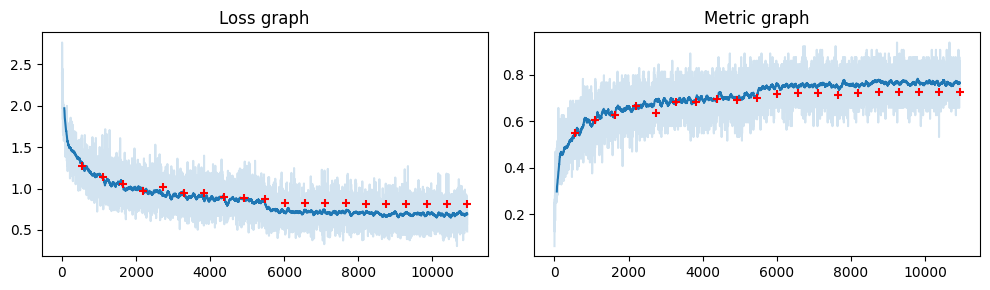

In [17]:
plot_loss_metrics(tr_loss_log, val_loss_log, tr_acc_log, val_acc_log)

**Задание 3.0 (0.5 баллов).** Здесь может возникнуть вопрос: а что будет, если мы не будем уменьшать длину шага в процессе обучения, а сразу возьмем констатную, равную значению нашей кусочно-постоянной функции на последних эпохах, то есть $0.001$ в нашем случае. Запустите обучение и проверьте, что в таком случае мы получим худшее качество на тестовой выборке.

In [18]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, fused=True)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader
)

Epoch 0
 train loss: 1.845, train acc: 0.352
 val loss: 1.625, val acc: 0.435

Epoch 1
 train loss: 1.556, train acc: 0.453
 val loss: 1.475, val acc: 0.484

Epoch 2
 train loss: 1.434, train acc: 0.497
 val loss: 1.403, val acc: 0.507

Epoch 3
 train loss: 1.353, train acc: 0.526
 val loss: 1.310, val acc: 0.543

Epoch 4
 train loss: 1.293, train acc: 0.549
 val loss: 1.256, val acc: 0.563

Epoch 5
 train loss: 1.238, train acc: 0.566
 val loss: 1.208, val acc: 0.583

Epoch 6
 train loss: 1.192, train acc: 0.584
 val loss: 1.162, val acc: 0.595

Epoch 7
 train loss: 1.146, train acc: 0.601
 val loss: 1.121, val acc: 0.612

Epoch 8
 train loss: 1.110, train acc: 0.615
 val loss: 1.088, val acc: 0.623

Epoch 9
 train loss: 1.077, train acc: 0.625
 val loss: 1.054, val acc: 0.631

Epoch 10
 train loss: 1.053, train acc: 0.636
 val loss: 1.049, val acc: 0.633

Epoch 11
 train loss: 1.027, train acc: 0.645
 val loss: 1.024, val acc: 0.643

Epoch 12
 train loss: 1.013, train acc: 0.651
 val

Test loss: 0.932, accuracy: 0.677


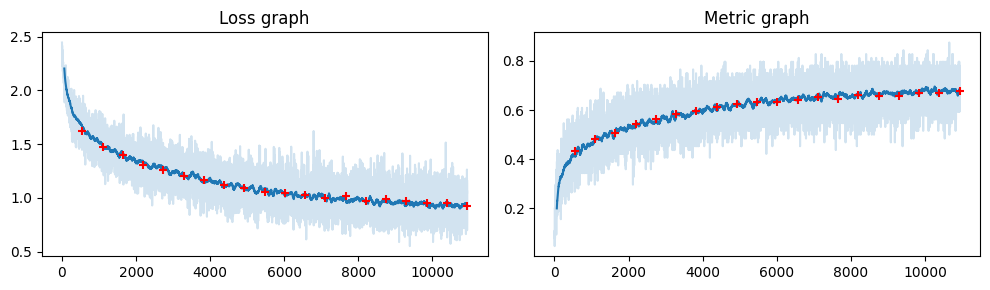

In [19]:
test_loss, test_acc = test(net, test_loader)
print(f"Test loss: {test_loss:.3f}, accuracy: {test_acc:.3f}")

plot_loss_metrics(tr_loss_log, val_loss_log, tr_acc_log, val_acc_log)

**Задание 3.1 (1.5 балла).** Изучите, какие еще способы уменьшения длины шага представлены в <code>torch.optim.lr_scheduler</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними. Удалось ли добиться улучшения качества на тестовой выборке?

In [20]:
# Уменьшение lr по косинусоиде

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, fused=True)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)

Epoch 0
 train loss: 1.482, train acc: 0.473
 val loss: 1.245, val acc: 0.571

Epoch 1
 train loss: 1.146, train acc: 0.600
 val loss: 1.057, val acc: 0.628

Epoch 2
 train loss: 1.036, train acc: 0.639
 val loss: 1.026, val acc: 0.643

Epoch 3
 train loss: 0.980, train acc: 0.661
 val loss: 1.080, val acc: 0.623

Epoch 4
 train loss: 0.938, train acc: 0.672
 val loss: 0.985, val acc: 0.655

Epoch 5
 train loss: 0.905, train acc: 0.685
 val loss: 1.048, val acc: 0.649

Epoch 6
 train loss: 0.881, train acc: 0.696
 val loss: 0.927, val acc: 0.680

Epoch 7
 train loss: 0.853, train acc: 0.705
 val loss: 0.899, val acc: 0.690

Epoch 8
 train loss: 0.832, train acc: 0.710
 val loss: 0.897, val acc: 0.691

Epoch 9
 train loss: 0.813, train acc: 0.719
 val loss: 0.887, val acc: 0.696

Epoch 10
 train loss: 0.788, train acc: 0.727
 val loss: 0.912, val acc: 0.692

Epoch 11
 train loss: 0.769, train acc: 0.735
 val loss: 0.856, val acc: 0.709

Epoch 12
 train loss: 0.752, train acc: 0.740
 val

Test loss: 0.807, accuracy: 0.722


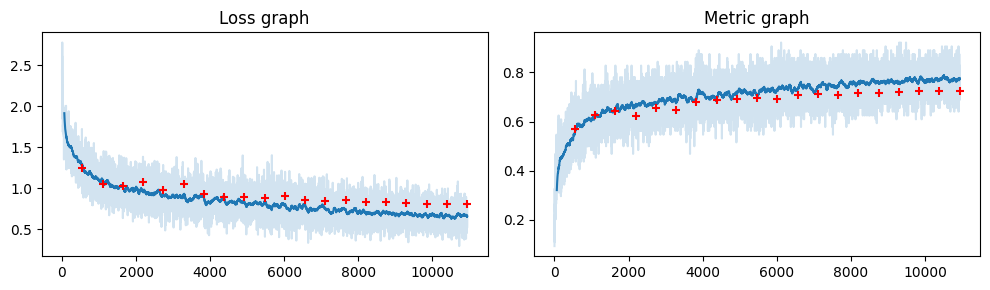

In [21]:
test_loss, test_acc = test(net, test_loader)
print(f"Test loss: {test_loss:.3f}, accuracy: {test_acc:.3f}")

plot_loss_metrics(tr_loss_log, val_loss_log, tr_acc_log, val_acc_log)

In [22]:
# Уменьшение lr ступенчато

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, fused=True)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)

Epoch 0
 train loss: 1.504, train acc: 0.462
 val loss: 1.301, val acc: 0.546

Epoch 1
 train loss: 1.207, train acc: 0.575
 val loss: 1.112, val acc: 0.613

Epoch 2
 train loss: 1.077, train acc: 0.626
 val loss: 1.036, val acc: 0.638

Epoch 3
 train loss: 1.010, train acc: 0.649
 val loss: 1.073, val acc: 0.633

Epoch 4
 train loss: 0.970, train acc: 0.662
 val loss: 0.961, val acc: 0.668

Epoch 5
 train loss: 0.838, train acc: 0.709
 val loss: 0.879, val acc: 0.699

Epoch 6
 train loss: 0.814, train acc: 0.720
 val loss: 0.878, val acc: 0.698

Epoch 7
 train loss: 0.806, train acc: 0.723
 val loss: 0.864, val acc: 0.703

Epoch 8
 train loss: 0.802, train acc: 0.723
 val loss: 0.858, val acc: 0.705

Epoch 9
 train loss: 0.794, train acc: 0.725
 val loss: 0.858, val acc: 0.706

Epoch 10
 train loss: 0.775, train acc: 0.732
 val loss: 0.847, val acc: 0.708

Epoch 11
 train loss: 0.773, train acc: 0.733
 val loss: 0.845, val acc: 0.708

Epoch 12
 train loss: 0.772, train acc: 0.733
 val

Test loss: 0.853, accuracy: 0.705


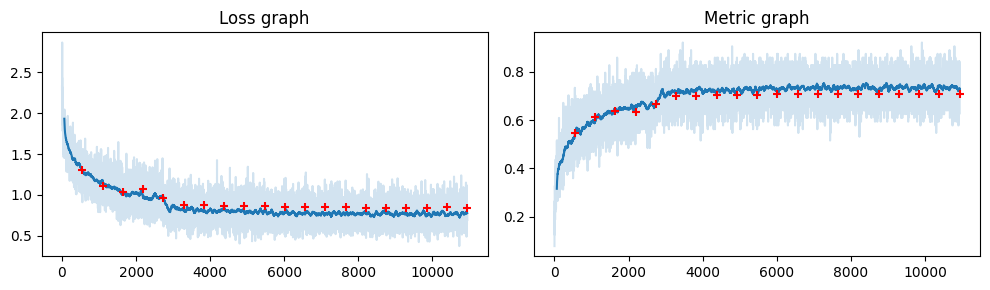

In [23]:
test_loss, test_acc = test(net, test_loader)
print(f"Test loss: {test_loss:.3f}, accuracy: {test_acc:.3f}")

plot_loss_metrics(tr_loss_log, val_loss_log, tr_acc_log, val_acc_log)

In [24]:
# Уменьшение lr при выходе на плато

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, fused=True)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)

Epoch 0
 train loss: 1.489, train acc: 0.469
 val loss: 1.251, val acc: 0.564

Epoch 1
 train loss: 1.172, train acc: 0.590
 val loss: 1.134, val acc: 0.608

Epoch 2
 train loss: 1.057, train acc: 0.633
 val loss: 1.049, val acc: 0.634

Epoch 3
 train loss: 0.997, train acc: 0.651
 val loss: 1.036, val acc: 0.644

Epoch 4
 train loss: 0.958, train acc: 0.666
 val loss: 1.042, val acc: 0.638

Epoch 5
 train loss: 0.925, train acc: 0.679
 val loss: 1.012, val acc: 0.650

Epoch 6
 train loss: 0.897, train acc: 0.691
 val loss: 0.965, val acc: 0.666

Epoch 7
 train loss: 0.881, train acc: 0.694
 val loss: 0.907, val acc: 0.688

Epoch 8
 train loss: 0.864, train acc: 0.701
 val loss: 0.948, val acc: 0.671

Epoch 9
 train loss: 0.849, train acc: 0.703
 val loss: 0.912, val acc: 0.685

Epoch 10
 train loss: 0.744, train acc: 0.744
 val loss: 0.829, val acc: 0.717

Epoch 11
 train loss: 0.727, train acc: 0.749
 val loss: 0.831, val acc: 0.718

Epoch 12
 train loss: 0.720, train acc: 0.751
 val

Test loss: 0.826, accuracy: 0.711


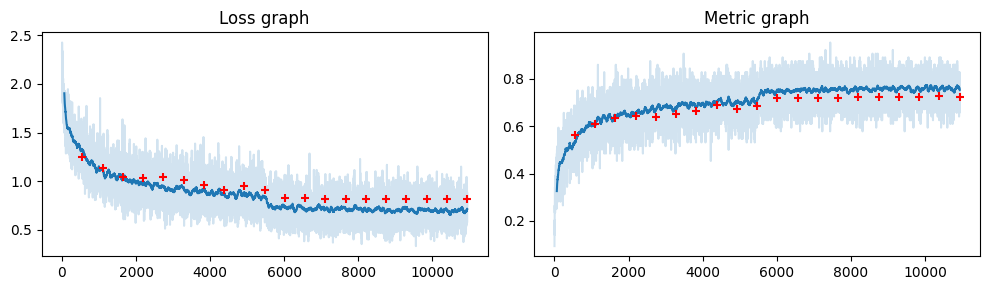

In [25]:
test_loss, test_acc = test(net, test_loader)
print(f"Test loss: {test_loss:.3f}, accuracy: {test_acc:.3f}")

plot_loss_metrics(tr_loss_log, val_loss_log, tr_acc_log, val_acc_log)

**Ответ:**

Изменение learning rate с помощью планировщиков оказалось более эффективным на горизонте 20 эпох.

- Без планировщиков: Test loss: 0.923, accuracy: 0.685  
- MultiStepLR: Test loss: 0.820, accuracy: 0.717  
- CosineAnnealingLR: Test loss: 0.807, accuracy: 0.722 
- StepLR(5): Test loss: 0.853, accuracy: 0.705
- ReduceLROnPlateau: Test loss: 0.826, accuracy: 0.711

Но возможно если поиграться с гиперпараметрами, что-то изменится.  
Так например StepLR(1) - дефолтный -  слишком быстро затухает и не достигает оптимального значения.

Плюс, здесь свою роль играет случайность: при перезапуске значения качества менялись,  
но они достаточно близки, так что тут все в пределах погрешности

## 4. Аугментации данных (2 балла)

Еще одной стандартной техникой, применяющейся в глубинном обучении, а особенно часто в компьютерном зрении, являются аугментации данных. Суть аугментаций состоит в том, что мы можем некоторым синтетическим образом видоизменять объекты обучающей выборки, тем самым расширяя ее, а также делая итоговую модель более устойчивой к таким изменениям.

Простейшая аугментация, которую можно применить к картинкам — разворот картинки по горизонтальной оси. То есть при обучении модели с вероятностью $0.5$ мы будем разворачивать картинку из обучающей выборки.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.49473685..1.5632443].


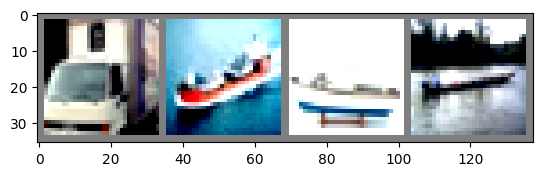

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.49473685..1.5632443].


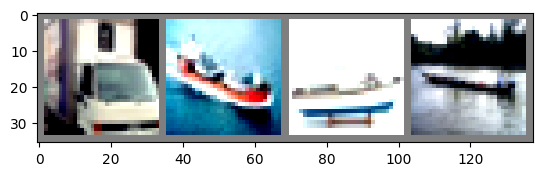

In [26]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

imshow(torchvision.utils.make_grid(transforms.functional.hflip(images[:4])))

Наиболее удобным способом работы с аугментациями в PyTorch является их задание в списке <code>transforms</code>, который затем передается в загрузчик данных. Обучим нашу сеть, применяя горизонтальные повороты:

In [27]:
transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        # Переделаем под v2
        # transforms.ToTensor(),
        transforms.ToImage(),
        transforms.ToDtype(torch.float32, scale=True),
        transforms.Normalize(mean, std),
    ]
)

train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=64, transform_train=transform
)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, fused=True)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)

Epoch 0
 train loss: 1.480, train acc: 0.475
 val loss: 1.282, val acc: 0.545

Epoch 1
 train loss: 1.160, train acc: 0.594
 val loss: 1.112, val acc: 0.607

Epoch 2
 train loss: 1.055, train acc: 0.632
 val loss: 1.014, val acc: 0.649

Epoch 3
 train loss: 1.000, train acc: 0.656
 val loss: 0.991, val acc: 0.662

Epoch 4
 train loss: 0.958, train acc: 0.668
 val loss: 0.956, val acc: 0.666

Epoch 5
 train loss: 0.928, train acc: 0.679
 val loss: 0.967, val acc: 0.658

Epoch 6
 train loss: 0.905, train acc: 0.687
 val loss: 0.898, val acc: 0.685

Epoch 7
 train loss: 0.891, train acc: 0.693
 val loss: 0.876, val acc: 0.700

Epoch 8
 train loss: 0.875, train acc: 0.697
 val loss: 0.900, val acc: 0.692

Epoch 9
 train loss: 0.853, train acc: 0.705
 val loss: 0.871, val acc: 0.704

Epoch 10
 train loss: 0.762, train acc: 0.737
 val loss: 0.795, val acc: 0.726

Epoch 11
 train loss: 0.746, train acc: 0.744
 val loss: 0.794, val acc: 0.729

Epoch 12
 train loss: 0.743, train acc: 0.746
 val

Посчитайте точность на тестовой выборке:

Test loss: 0.790, accuracy: 0.727


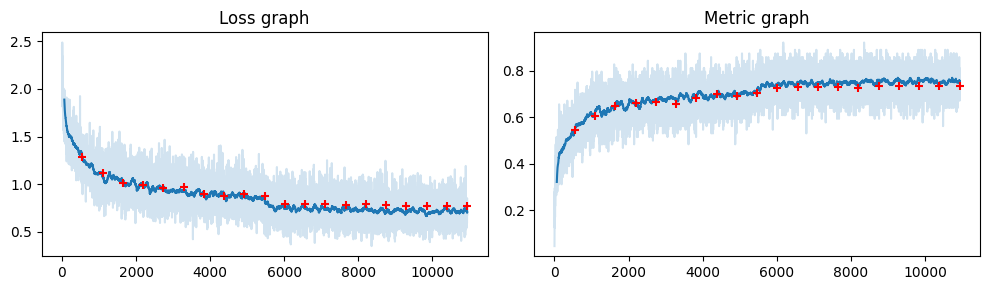

In [28]:
test_loss, test_acc = test(net, test_loader)
print(f"Test loss: {test_loss:.3f}, accuracy: {test_acc:.3f}")

plot_loss_metrics(tr_loss_log, val_loss_log, tr_acc_log, val_acc_log)

**Задание 4.1 (2 балла).** Изучите, какие еще способы аугментаций изображений представлены в <code>torchvision.transforms</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними (по отдельности и вместе). Удалось ли добиться улучшения качества на тестовой выборке?

Уже есть готовая `transforms.AutoAugmentPolicy.CIFAR10` которая включает в себя ряд преобразований данных, но возьмем свои, ради интереса:
- `transforms.ColorJitter()` - случайно меняет яркость, контраст, насыщенность и hue
- `transforms.RandomRotation()` - случайно поворачивает изображения

Они все довольно подробно описаны в доке: [ссылка](https://pytorch.org/vision/0.21/auto_examples/transforms/plot_transforms_illustrations.html#sphx-glr-auto-examples-transforms-plot-transforms-illustrations-py)

Обучаем вместе:

In [29]:
transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomRotation(degrees=(-10, 10)),
        transforms.ToImage(),
        transforms.ToDtype(torch.float32, scale=True),
        transforms.Normalize(mean, std),
    ]
)

train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=64, transform_train=transform
)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, fused=True)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)

Epoch 0
 train loss: 1.587, train acc: 0.433
 val loss: 1.392, val acc: 0.506

Epoch 1
 train loss: 1.285, train acc: 0.549
 val loss: 1.218, val acc: 0.573

Epoch 2
 train loss: 1.180, train acc: 0.588
 val loss: 1.153, val acc: 0.600

Epoch 3
 train loss: 1.118, train acc: 0.609
 val loss: 1.242, val acc: 0.581

Epoch 4
 train loss: 1.084, train acc: 0.622
 val loss: 1.145, val acc: 0.604

Epoch 5
 train loss: 1.054, train acc: 0.629
 val loss: 1.055, val acc: 0.623

Epoch 6
 train loss: 1.033, train acc: 0.642
 val loss: 1.052, val acc: 0.631

Epoch 7
 train loss: 1.020, train acc: 0.646
 val loss: 1.013, val acc: 0.648

Epoch 8
 train loss: 1.015, train acc: 0.647
 val loss: 1.021, val acc: 0.651

Epoch 9
 train loss: 0.988, train acc: 0.657
 val loss: 1.049, val acc: 0.643

Epoch 10
 train loss: 0.906, train acc: 0.686
 val loss: 0.913, val acc: 0.685

Epoch 11
 train loss: 0.886, train acc: 0.693
 val loss: 0.906, val acc: 0.688

Epoch 12
 train loss: 0.884, train acc: 0.692
 val

Test loss: 0.832, accuracy: 0.716


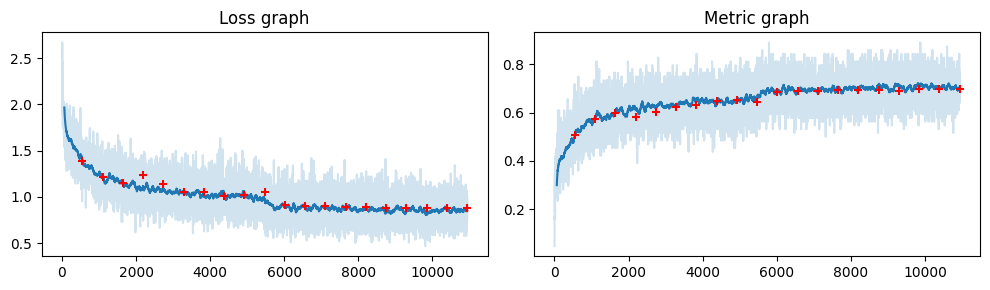

In [30]:
test_loss, test_acc = test(net, test_loader)
print(f"Test loss: {test_loss:.3f}, accuracy: {test_acc:.3f}")

plot_loss_metrics(tr_loss_log, val_loss_log, tr_acc_log, val_acc_log)

Обучим только с использованием  `ColorJitter`:

In [31]:
transform = transforms.Compose(
    [
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToImage(),
        transforms.ToDtype(torch.float32, scale=True),
        transforms.Normalize(mean, std),
    ]
)

train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=64, transform_train=transform
)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, fused=True)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)

Epoch 0
 train loss: 1.531, train acc: 0.456
 val loss: 1.281, val acc: 0.545

Epoch 1
 train loss: 1.203, train acc: 0.582
 val loss: 1.114, val acc: 0.614

Epoch 2
 train loss: 1.092, train acc: 0.620
 val loss: 1.113, val acc: 0.622

Epoch 3
 train loss: 1.047, train acc: 0.639
 val loss: 1.040, val acc: 0.647

Epoch 4
 train loss: 1.011, train acc: 0.651
 val loss: 1.071, val acc: 0.628

Epoch 5
 train loss: 0.974, train acc: 0.663
 val loss: 0.991, val acc: 0.651

Epoch 6
 train loss: 0.954, train acc: 0.671
 val loss: 1.019, val acc: 0.649

Epoch 7
 train loss: 0.940, train acc: 0.677
 val loss: 0.992, val acc: 0.659

Epoch 8
 train loss: 0.925, train acc: 0.679
 val loss: 0.958, val acc: 0.671

Epoch 9
 train loss: 0.900, train acc: 0.690
 val loss: 0.934, val acc: 0.686

Epoch 10
 train loss: 0.805, train acc: 0.724
 val loss: 0.856, val acc: 0.707

Epoch 11
 train loss: 0.786, train acc: 0.733
 val loss: 0.855, val acc: 0.708

Epoch 12
 train loss: 0.776, train acc: 0.733
 val

Test loss: 0.824, accuracy: 0.721


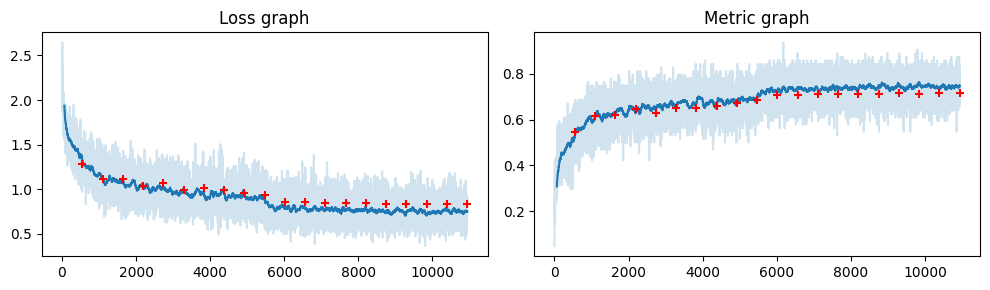

In [32]:
test_loss, test_acc = test(net, test_loader)
print(f"Test loss: {test_loss:.3f}, accuracy: {test_acc:.3f}")

plot_loss_metrics(tr_loss_log, val_loss_log, tr_acc_log, val_acc_log)

In [33]:
transform = transforms.Compose(
    [
        transforms.RandomRotation(degrees=(-10, 10)),
        transforms.ToImage(),
        transforms.ToDtype(torch.float32, scale=True),
        transforms.Normalize(mean, std),
    ]
)

train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=64, transform_train=transform
)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, fused=True)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)

Epoch 0
 train loss: 1.532, train acc: 0.450
 val loss: 1.266, val acc: 0.552

Epoch 1
 train loss: 1.223, train acc: 0.568
 val loss: 1.158, val acc: 0.591

Epoch 2
 train loss: 1.122, train acc: 0.606
 val loss: 1.099, val acc: 0.621

Epoch 3
 train loss: 1.060, train acc: 0.627
 val loss: 1.042, val acc: 0.641

Epoch 4
 train loss: 1.021, train acc: 0.642
 val loss: 1.085, val acc: 0.620

Epoch 5
 train loss: 0.992, train acc: 0.652
 val loss: 1.065, val acc: 0.625

Epoch 6
 train loss: 0.966, train acc: 0.661
 val loss: 0.994, val acc: 0.650

Epoch 7
 train loss: 0.956, train acc: 0.664
 val loss: 0.961, val acc: 0.668

Epoch 8
 train loss: 0.942, train acc: 0.671
 val loss: 0.960, val acc: 0.666

Epoch 9
 train loss: 0.919, train acc: 0.681
 val loss: 0.929, val acc: 0.678

Epoch 10
 train loss: 0.818, train acc: 0.714
 val loss: 0.873, val acc: 0.703

Epoch 11
 train loss: 0.805, train acc: 0.721
 val loss: 0.868, val acc: 0.702

Epoch 12
 train loss: 0.797, train acc: 0.721
 val

Test loss: 0.829, accuracy: 0.713


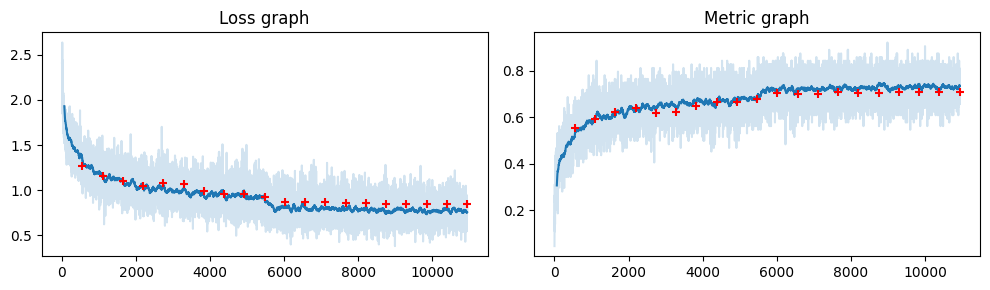

In [34]:
test_loss, test_acc = test(net, test_loader)
print(f"Test loss: {test_loss:.3f}, accuracy: {test_acc:.3f}")

plot_loss_metrics(tr_loss_log, val_loss_log, tr_acc_log, val_acc_log)

Полученные результаты:
- **Только нормализация**: Test loss: 0.820, accuracy: 0.717
- **RHF**: Test loss: 0.790, accuracy: 0.727
- **RHF+CJ+RR**: Test loss: 0.832, accuracy: 0.716
- **CJ**: Test loss: 0.824, accuracy: 0.721
- **RR**: Test loss: 0.829, accuracy: 0.713

\* RHF - RandomHorizontalFlip, CJ - ColorJitter, RR - RandomRotation

На самом деле результаты довольно близкие после 20 эпох, но чистый RHF дал больший прирост, а RR негативно влияет на результат.  
Это может быть связано с тем, что разрешение изображений достаточно небольшое и поворот просто их искажает, мешая модели.  

## Бонус. Логирование в wandb (1 балл)

На практике специалиста по глубинному обучению часто встречаются ситуации, когда нейросеть учится на каком-то удаленном сервере. И обычно вам хочется отслеживать прогресс обучения, особенно когда время обучения модели исчисляется днями или неделями. Для таких целей существует несколько инструментов. Вероятно, самый популярный из них — [wandb](https://wandb.ai/site).

Ваша задача состоит в том, чтобы разобраться как им пользоваться, и повторить задания 2.1 и 2.2 с его использованием. Обучение вы можете запускать в этом же ноутбуке, но теперь вам необходимо через wandb логировать значения функции потерь и точности на обучающей выборке и на валидационной. Результатом работы должны быть ваш код и публичная ссылка на страничку с графиками, идентичными графикам в задании 2.2.

Если вас смущает, что WandB грозится забанить вас, то можете разобраться с любым его аналогом и приложить ссылку на аналог.

In [11]:
import wandb

wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: vaalkaev (vaalkaev-hse) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

Мне показалась странной идея логировать ошибку на каждом батче или наблюдении, поэтому графики будут менее периодичными и отражать ошибку на обучающей и валидационной выборке раз в эпоху

In [14]:
# Сделаем упрощенную версию, в которой нет лишних выводов в консоль
def train_simple(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None, wandb_logger=None):
    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)

        avg_train_loss = np.mean(train_loss)
        avg_train_acc = np.mean(train_acc)

        if wandb_logger is not None:
            wandb_logger.log(
                {
                    "train/loss": avg_train_loss,
                    "train/accuracy": avg_train_acc,
                    "val/loss": val_loss,
                    "val/accuracy": val_acc
                }
            )

        if scheduler is not None:
            if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_loss)
            else:
                scheduler.step()

In [12]:
n_epochs = 30
learning_rate = 0.1
momentum = 0.9

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum, fused=True)

run = wandb.init(
    entity="vaalkaev-hse",
    project="DL_HW2",
    name="experiment-1",
    config={
        "learning_rate": learning_rate,
        "optimizer": optimizer.__class__.__name__,
        "momentum": momentum,
        "architecture": "ResNet-like",
        "dataset": "CIFAR-10",
        "epochs": n_epochs,
    },
)

train_simple(net, optimizer, n_epochs, train_loader, val_loader, wandb_logger=run)
run.finish()

train/accuracy,▁▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇██████████
train/loss,█▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val/accuracy,▁▄▅▅▆▆▆▇▇▇▇▆▇▇▇▇▇▇▇▇▇█████▇▇▇█
val/loss,█▆▄▄▃▃▃▂▂▂▂▃▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▂▁▁
train/accuracy,0.75697
train/loss,0.69477
val/accuracy,0.72327
val/loss,0.83109


Интереса ради посмотрим на `Adam`

In [17]:
n_epochs = 30
learning_rate = 0.001

net = BasicBlockNet().to(device)
optimizer = optim.Adam(net.parameters(), lr=learning_rate, fused=True)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, patience=3)

run = wandb.init(
    entity="vaalkaev-hse",
    project="DL_HW2",
    name="experiment-2",
    config={
        "learning_rate": learning_rate,
        "optimizer": optimizer.__class__.__name__,
        "scheduler": scheduler.__class__.__name__,
        "architecture": "ResNet-like",
        "dataset": "CIFAR-10",
        "epochs": n_epochs,
    },
)

train_simple(net, optimizer, n_epochs, train_loader, val_loader, scheduler, run)
run.finish()

train/accuracy,▁▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███
train/loss,█▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁
val/accuracy,▁▃▃▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█▇▇▇████
val/loss,█▆▆▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▁▁▁
train/accuracy,0.77563
train/loss,0.6588
val/accuracy,0.7418
val/loss,0.74883


> [Ссылка](https://api.wandb.ai/links/vaalkaev-hse/4ltuengh) на репорт wandb